# Разберем, как работает самая простая классификация
- собственная переработка в более доступной форме этот статьи https://habr.com/ru/post/517556/
- https://machinelearningmastery.ru/decision-tree-from-scratch-in-python-46e99dfea775/  #когда-нибудь разберу


In [324]:
import math
import pandas as pd
from functools import reduce

# Датасет
d = {
    "Погода":["ясно","ясно","облачно","дождь","дождь","дождь","облачно","ясно","ясно","дождь","ясно","облачно","облачно","дождь"],
    "Температура":["Жарко","Жарко","Жарко","Тепло","Холодно","Холодно","Холодно","Тепло","Холодно","Тепло","Тепло","Тепло","Жарко","Тепло"], 
    "Влажность":["Высокая","Высокая","Высокая","Высокая","Норм","Норм","Норм","Высокая","Норм","Норм","Норм","Высокая","Норм","Высокая"],
    "Ветер":["Нет","Есть","Нет","Нет","Нет","Есть","Есть","Нет","Нет","Нет","Есть","Есть","Нет","Есть"],
    # Последний массив - это наша целевая переменная, показывающая результат, 
    # основывающийся на предыдущих данных.
    "Гольф":["×","×","○","○","○","×","○","×","○","○","○","○","○","×"],
}
df0 = pd.DataFrame(d)

In [325]:
df0

,Погода,Температура,Влажность,Ветер,Гольф
0,ясно,Жарко,Высокая,Нет,×
1,ясно,Жарко,Высокая,Есть,×
2,облачно,Жарко,Высокая,Нет,○
3,дождь,Тепло,Высокая,Нет,○
4,дождь,Холодно,Норм,Нет,○
5,дождь,Холодно,Норм,Есть,×
6,облачно,Холодно,Норм,Есть,○
7,ясно,Тепло,Высокая,Нет,×
8,ясно,Холодно,Норм,Нет,○
9,дождь,Тепло,Норм,Нет,○


### Создадим словарь с первым уровнем классификатора
Следующие уровни будем добавлять в список "edges"

In [326]:
tree = {
    # name: Название этого нода (узла)
    "name":"decision tree "+df0.columns[-1],
    # df: Данные, связанные с этим нодом (узлом)
    "df":df0,
    # edges: Список ребер (ветвей), выходящих из этого узла, 
    # или пустой массив, если ниже нет листового узла.
    "edges":[],
}

In [327]:
tree

{'name': 'decision tree Гольф',
 'df':      Погода Температура Влажность Ветер Гольф
 0      ясно       Жарко   Высокая   Нет     ×
 1      ясно       Жарко   Высокая  Есть     ×
 2   облачно       Жарко   Высокая   Нет     ○
 3     дождь       Тепло   Высокая   Нет     ○
 4     дождь     Холодно      Норм   Нет     ○
 5     дождь     Холодно      Норм  Есть     ×
 6   облачно     Холодно      Норм  Есть     ○
 7      ясно       Тепло   Высокая   Нет     ×
 8      ясно     Холодно      Норм   Нет     ○
 9     дождь       Тепло      Норм   Нет     ○
 10     ясно       Тепло      Норм  Есть     ○
 11  облачно       Тепло   Высокая  Есть     ○
 12  облачно       Жарко      Норм   Нет     ○
 13    дождь       Тепло   Высокая  Есть     ×,
 'edges': []}

### Считаем энтропию
Напишем функцию, вычисляющую энтропию, для объекта Series (Shannon entropy):

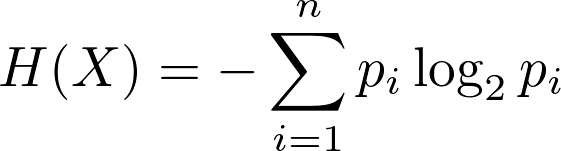

In [328]:
entropy = lambda s:-reduce(lambda x,y:x+y,map(lambda x:(x/len(s))*math.log2(x/len(s)),s.value_counts()))

In [329]:
entropy(df0['Гольф']) # энтропия для нашего датафрейма

0.9402859586706311

### Анализ узла, поиск оптимального разбиения

In [330]:
# список 'open' нужен для того, чтобы добавлять туда наш узел
# первым узлом будет все дерево tree
# затем методом 'pop' мы вытащим этот узел из списка (список станет пустым) и потом добавим в него низостоящие узлы
# узлов следующего уровня будет больше чем 1 (в зависимости от количества уникальных значений в признаке set(df_n[attr]))
# образованные при разбиении признака с наименьшей энтропией
open = [tree]

In [331]:
n = open.pop(0) #n = tree, open = []
df_n = n["df"] # df_n - наш первоначальный датафрейм

In [332]:
attrs = {}

In [333]:
# в цикле мы оцениваем каждый узел, вытащенный из 'open' (полный код в самом низу)
#Если у него энтропия=0 (все значения таргета одинаковые)
# то нам нет смысла разбивать узел дальше, мы возвращается к условию while
#n = open.pop(0)
#df_n = n["df"]
# if 0==entropy(df_n.iloc[:,-1]):
# continue
for attr in df_n.columns[:-1]:
    attrs[attr] = {"entropy":0,"dfs":[],"values":[]} # создаем пустой словарь словарей
    for value in sorted(set(df_n[attr])):
        df_m = df_n.query(attr+'==@value') #фильтруем датасеты по value, т.е. df['Погода'] == 'дождь'
        attrs[attr]["entropy"] += entropy(df_m.iloc[:,-1])*df_m.shape[0]/df_n.shape[0] # складываем энтропии с учетом 
        #соотношения отфильтрованной по value df к df_n - первоначальному датафрейму
        attrs[attr]["dfs"] += [df_m]
        attrs[attr]["values"] += [value]

In [334]:
for key, item in attrs.items():
    print(key, item['entropy']) # перечень колонок df их энтропии. Минимальная - 'Погода'
# можно отметить, что энтропия при лучшем разбиении существенно снизилась: была 0.94, стала - 0.69

Погода 0.6935361388961919
Температура 0.9110633930116763
Влажность 0.7884504573082896
Ветер 0.8921589282623617


In [335]:
attr = min(attrs,key=lambda x:attrs[x]["entropy"]) # Минимальная сумма энтропий - 'Погода' 
#(оптимальное деление по этой колонке)

### Формируем новые узлы исходя из деления по оптимальному признаку (колонке)
- Добавляем узлы в список "edges" словаря tree
- Добавляем узлы в список 'open' для их дальшейшего анализа и разбиения на нижестоящие узлы
- При формировании узлов, из df удаляем признак, по которому они были образованы (d.drop(columns=attr))

In [336]:
for d,v in zip(attrs[attr]["dfs"], attrs[attr]["values"]): # выбираем из словаря список с отфильтрованными датафреймами
    # и список со значениями, по которым фильтовали
    m = {"name":attr+"="+v,"df":d.drop(columns=attr), "edges":[]} # m = Погода+v(Value) + отфильтрованный датафрейм без 
    # колонки 'Погода' - по ней уже отработали
    n["edges"].append(m) # добавляем в n["edges"] (а по факту в tree["edges"]) новые словари (узлы) аналогичной структуры
    # что и в изначальном tree
    open.append(m) # добавляем в open новые узлы, в случае с 'Погодой' - 3 шт.

In [337]:
# в tree'edges' появились три словаря при разбиении по колонке с меньшей энтропией (Погода)
# и в этих словарях появились свои списки 'edges' (пока пустые), куда после анализа будут добавляться следующие узлы
for index in range(len(tree['edges'])):
    print('Узел:', tree['edges'][index]['name'])
    print('Датафрейм:')
    print(tree['edges'][index]['df'])
    print('Список для следующих узлов:', tree['edges'][index]['edges'])
    print('-'*40)

Узел: Погода=дождь
Датафрейм:
   Температура Влажность Ветер Гольф
3        Тепло   Высокая   Нет     ○
4      Холодно      Норм   Нет     ○
5      Холодно      Норм  Есть     ×
9        Тепло      Норм   Нет     ○
13       Тепло   Высокая  Есть     ×
Список для следующих узлов: []
----------------------------------------
Узел: Погода=облачно
Датафрейм:
   Температура Влажность Ветер Гольф
2        Жарко   Высокая   Нет     ○
6      Холодно      Норм  Есть     ○
11       Тепло   Высокая  Есть     ○
12       Жарко      Норм   Нет     ○
Список для следующих узлов: []
----------------------------------------
Узел: Погода=ясно
Датафрейм:
   Температура Влажность Ветер Гольф
0        Жарко   Высокая   Нет     ×
1        Жарко   Высокая  Есть     ×
7        Тепло   Высокая   Нет     ×
8      Холодно      Норм   Нет     ○
10       Тепло      Норм  Есть     ○
Список для следующих узлов: []
----------------------------------------


### Визуализация Decision Tree

In [338]:
# эта строчка нужна для названия нашего классификатора (количество 'o' и 'x' в таргете)
cstr = lambda s:[k+":"+str(v) for k,v in sorted(s.value_counts().items())]

In [339]:
sorted(df0['Гольф'].value_counts().items()) # pandas.Series.items / + можно вытащать значения через цикл

[('×', 5), ('○', 9)]

In [340]:
def tstr(tree,indent=""):
    # Создаем символьное представление этого узла.
    # Если этот узел является листовым узлом (количество элементов в массиве ребер равно 0), 
    # частотное распределение последнего столбца данных df, связанных с деревом, преобразуется в символы.
    s = indent+tree["name"]+str(cstr(tree["df"].iloc[:,-1])) +"\n"
    #indent - это отступ для структуры
    # Зацикливаем все ветви этого узла.
    for e in tree["edges"]:
        # Добавляем символьное представление дочернего узла к символьному представлению родительского узла.
        # Добавляем еще больше символов к indent этого узла.
        s += tstr(e,indent+"---")
        pass
    return s

In [341]:
print(tstr(tree))

decision tree Гольф['×:5', '○:9']
---Погода=дождь['×:2', '○:3']
---Погода=облачно['○:4']
---Погода=ясно['×:3', '○:2']



Можно отметить, что узел 'Погода=облачно' дальше разветвляться уже не будет, т.е. энтропия в этом узле будет равна нулю.

### Здесь приведен полный код, те же действия, что мы проделали на первой уровне, но до исчерпания всех колонок. 
Тут его не запускаем, т.к. теряем в наглядности, если хотим изучить tree